In [25]:
import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_rm_dataset

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["eval_ranking_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_ranking_rm"

# Create a Namespace object for config
config_ranking = argparse.Namespace(**config)

config = {}
config.update(conf["default"])
config.update(conf["eval_abs_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_abs_rm"

# Create a Namespace object for config
config_abs = argparse.Namespace(**config)
 
config_abs.dataset["oasst_export_abs"]["label_weight"] = {"non violence": 0.05, "creativity": 0.15,
"helpfulness": 0.25, "humor": 0.05, "non toxicity": 0.15, "quality": 0.35
}




config_abs.dataset["oasst_export_abs"]["top_k"]=1

"""Quality: Since quality directly pertains to how good, informative, and comprehensive the answer is, it should have the highest weight.

Weight: 0.4
Helpfulness: An answer's primary goal, especially in this context, is to be helpful. If it's not helping the user understand or solve a problem, its value diminishes.

Weight: 0.25
Creativity: While creativity might not be as crucial as quality or helpfulness, a creative response can provide more insight or a fresh perspective.

Weight: 0.15
Toxicity: It's vital to ensure responses are not toxic. However, since the provided responses were largely non-toxic, this label might not need a very high weight. Still, it's essential to consider it.

Weight: 0.1 (This would work in a negative fashion, where higher toxicity reduces the overall score.)
Violence: Similar to toxicity, ensuring non-violence is crucial. Since the given responses didn't exhibit violence, this can have a smaller weight.

Weight: 0.05 (Again, this would work negatively.)
Humor: While humor can be a bonus, it's not necessarily a priority in this context. Therefore, it should have the lowest weight.

Weight: 0.05

"""


# """
# Given the clarified requirements and the focus on ensuring that the scalar reward reflects the desired properties of helpfulness, harmlessness, quality, and entertainment, let's proceed.

# Non-violence & Non-toxicity (After Subtracting from 1): Since higher values are now desirable, and the majority of the data is skewed toward these values, these metrics will dominate the scalar reward if given too much weight. While harmlessness is a priority, we don't want it overshadowing helpfulness.

# Helpfulness: This is a core metric. The response must be helpful for a general-purpose chatbot, so this should carry a significant weight. However, we don't want a harmless but unhelpful response to get a high reward.

# Quality: This essentially determines the coherence, relevance, and overall acceptability of the response. It's a fundamental metric.

# Creativity & Humor: Both these metrics add to the entertaining aspect. Humor might not always be relevant in every context, so while it should have a weight, it shouldn't be too high. Creativity, on the other hand, could be desirable more often as it can provide unique and insightful responses.

# Based on the above considerations, here's a suggested distribution:

# Non-violence: 0.20
# Non-toxicity: 0.20
# Helpfulness: 0.30
# Quality: 0.20
# Creativity: 0.05
# Humor: 0.05
# This distribution sums up to 1. The logic here is:

# Harmlessness (Non-violence and Non-toxicity) collectively gets a weight of 0.40. This ensures the chatbot doesn't produce harmful content.
# Helpfulness is given a significant weight (0.30) so that utility is prioritized.
# Quality is given an equal weight as harmlessness metrics because for a general-purpose chatbot, the quality of response matters.
# Entertainment (Creativity and Humor) gets a collective weight of 0.10, ensuring the chatbot can be engaging but without compromising on the core objectives.
# This distribution aims to balance the objectives laid out and mitigate the effects of the skewness in the data for non-violence and non-toxicity.
# """



train_e , eval_abs = load_rm_dataset(config_abs)

train_er , eval_ranking = load_rm_dataset(config_ranking)


===loading the oasst_export_abs dataset===

{'non violence': 0.05, 'creativity': 0.15, 'helpfulness': 0.25, 'humor': 0.05, 'non toxicity': 0.15, 'quality': 0.35}
============================== total 538 has None value for atleast 1 label
============================== total 3442 has been skipped because low difference threshold
============================== Oversample count 4312
{'non violence': 0.05, 'creativity': 0.15, 'helpfulness': 0.25, 'humor': 0.05, 'non toxicity': 0.15, 'quality': 0.35}
============================== total 23 has None value for atleast 1 label
============================== total 164 has been skipped because low difference threshold
OASST HF dataset: len(train)=29310, len(val)=1307
Size of oasst_export_abs training data: 29310
Size of oasst_export_abs validation data: 1307
============================== Total training dataset size is 29310...
	============================== Validation size for oasst_export_abs dataset size is 1307...
===loading the oasst_expor

In [27]:
len([ss for ss in s if ss <= 0.5 ]) #38852/3354

8624

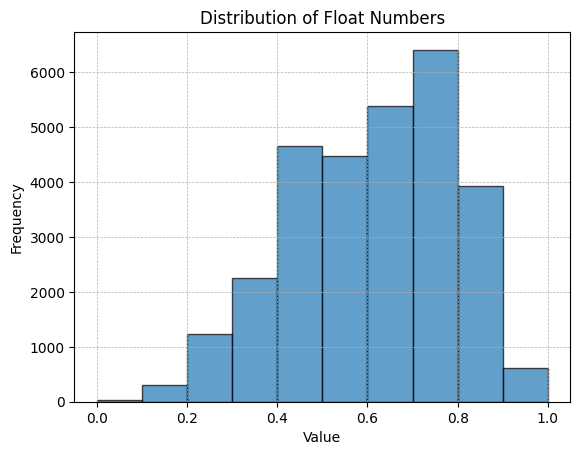

In [26]:
s = []

for e in train_e:
    prefix, reply, score = e
    s.append(score)

# for e in eval_abs["oasst_export_abs"]:
#     prefix, reply, score = e
#     s.append(score)

import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(s, bins=10, edgecolor="k", alpha=0.7)
plt.title("Distribution of Float Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [4]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel

model_args = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        ),
    "cache_dir": 'cache',
    "device_map": {"":0},
}

model_name = 'output/sft/LLama-2-7b_crs_oasst_sft_bs64/merged/'

abs_adapter_mean_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64/final_checkpoint"
abs_adapter_wavg_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg/final_checkpoint"
# abs_adapter2_wavg_l2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5/final_checkpoint"
abs_adapter3_wavg_l2_no_sig_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5_no_sigmoid/final_checkpoint"
abs_adapter4_wavg_no_sig_os_at05_wgt_loss_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05_wgt_loss/final_checkpoint"
abs_adapter4_wavg_no_sig_os_at05_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05/final_checkpoint"

# abs_adapter4_no_sig_v2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v2_l2_1e-5_no_sigmoid/final_checkpoint"
abs_adapter5_no_sig_v3_oversampled ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_oversampled/final_checkpoint"
abs_adapter5_no_sig_v3_d02 ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_wgt_loss_115_d_0.2/final_checkpoint"

# abs_adapter = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_test_replication/final_checkpoint"
ranking_adapter_name= "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_reward_model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=1, **model_args
    )
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, cache_dir='cache')


base_reward_model = PeftModel.from_pretrained(
    base_reward_model,
    ranking_adapter_name,
    adapter_name="abs",
    is_trainable=False
    )
base_reward_model.load_adapter(abs_adapter_mean_name,adapter_name="abs_mean",is_trainable=False)
base_reward_model.load_adapter(abs_adapter_wavg_name,adapter_name="abs_wavg",is_trainable=False)

# base_reward_model.load_adapter(abs_adapter2_wavg_l2_name,adapter_name="abs_l2",is_trainable=False)
base_reward_model.load_adapter(abs_adapter3_wavg_l2_no_sig_name,adapter_name="abs_no_sig",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter4_no_sig_v2_name,adapter_name="abs_no_sig_v2",is_trainable=False)

base_reward_model.load_adapter(abs_adapter4_wavg_no_sig_os_at05_wgt_loss_top_1_name,adapter_name="top_1_wgt_loss",is_trainable=False)
base_reward_model.load_adapter(abs_adapter4_wavg_no_sig_os_at05_top_1_name,adapter_name="top_1",is_trainable=False)

base_reward_model.load_adapter(abs_adapter5_no_sig_v3_oversampled,adapter_name="v3_oversampled",is_trainable=False)
base_reward_model.load_adapter(abs_adapter5_no_sig_v3_d02,adapter_name="v3_wgt",is_trainable=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at output/sft/LLama-2-7b_crs_oasst_sft_bs64/merged/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs_mean.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs_wavg.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs_no_sig.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.top_1_wgt_loss.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs_mean.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs_wavg.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs_no_sig.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.top_1_wgt_loss.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_pro

In [5]:
base_reward_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (abs): Dropout(p=0.1, inplace=False)
                  (abs_mean): Dropout(p=0.1, inplace=False)
                  (abs_wavg): Dropout(p=0.1, inplace=False)
                  (abs_no_sig): Dropout(p=0.1, inplace=False)
                  (top_1_wgt_loss): Dropout(p=0.1, inplace=False)
                  (top_1): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (abs): Linear(in_features=4096, out_features=64, bias=False)
                  (abs_mean): Linear(in_features=40

In [6]:
from training_datasets.collators import AbsoluteScoreDataCollator, RankingDataCollator


abs_collate_fn = AbsoluteScoreDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
)

ranking_collate_fn = RankingDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
    max_replies=config_ranking.max_replies
)

# eval_abs,eval_ranking

In [20]:
def get_reward(inputs,adapter_name):
        print(f"{'=='*10}{adapter_name}")
        base_reward_model.set_adapter(adapter_name)
        logits = base_reward_model(input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                use_cache=False,
                ).logits
        s = sigmoid(logits)
        for idx in range(logits.shape[0]):
            print(f'sigmoid: {s[idx]},original: {logits[idx]}')
        print('==='*10)

idx = 75

# data = eval_abs["oasst_export_abs"][idx]
# inputs = abs_collate_fn([data])
# labels = inputs.pop("labels")
# print(f'label:{labels}')

sigmoid = torch.nn.Sigmoid()

data = [["Hi how are you?"],["I am good you piece of shit","Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish","I am good","I am good, how are you doing? Please tell me how can I help you? "]] 
data = eval_ranking["oasst_export"][idx]
inputs, _ = ranking_collate_fn([data])
print('***'*10)
for d in tokenizer.batch_decode(inputs.input_ids):
        print(f'{d}')


# base_reward_model.load_adapter(abs_adapter_mean_name,adapter_name="abs_mean",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter_wavg_name,adapter_name="abs_wavg",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter3_wavg_l2_no_sig_name,adapter_name="abs_no_sig",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter4_wavg_no_sig_os_at05_wgt_loss_top_1_name,adapter_name="top_1_wgt_loss",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter4_wavg_no_sig_os_at05_top_1_name,adapter_name="top_1",is_trainable=False)

# base_reward_model.load_adapter(abs_adapter5_no_sig_v3_oversampled,adapter_name="v3_oversampled",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter5_no_sig_v3_d02,adapter_name="v3_wgt",is_trainable=False)

for adp_name in ["abs_mean","abs_wavg","abs_no_sig","v3_oversampled","v3_wgt","top_1_wgt_loss","top_1","abs"]:
    get_reward(inputs,adp_name)   


******************************
<s><|prompter|> write me a 50 word anecdote on why dinosaurs can eat ice cream without having a brain freeze</s><|assistant|> Dinosaurs can eat ice cream but not get brain freeze due to their differing skull structure than humans. Human's skulls are quite thin between the roof of the mouth and brain, but since dinosaurs' are much thicker on average, the coldness of the ice cream cannot cause a brain freeze.</s><|prompter|> That's not an anecdote. An anecdote is a short account of an interesting or a humorous incident.</s><s><|assistant|> Alright, let me try again. Verne the Velociraptor once ate a whole can of ice cream in one giant bite. Normally, this would cause a huge brain freeze, but their dinosaur skull was thicker than a human skull, so they were just fine. Lucky dinosaurs!</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

In [ ]:
tokenizer.decode(inputs.input_ids[1])

## SFT


In [ ]:
import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_sft_dataset, load_rm_dataset
from training_datasets.collators import DialogueDataCollator

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["sft_eval"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "sft_eval"

# Create a Namespace object for config
config_ns = argparse.Namespace(**config)

init_or_resume_from(config_ns)

In [ ]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel
from model_training.training_utils import resize_embeddings

model_args = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        ),
    "cache_dir": 'cache',
    "device_map": {"":0},
}

model_name = 'meta-llama/Llama-2-7b-hf'
ep2 = "output/archive/LLama-2-7b_ours_oasst_sft_ep_2_lr_1e4_cosine_bs64_qlora_default/final_checkpoint"
crs = "output/sft/LLama-2-7b_crs_oasst_sft_bs64/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name, **model_args
    )

ep2_tokenizer = transformers.AutoTokenizer.from_pretrained(ep2, cache_dir='cache')
crs_tokenizer = transformers.AutoTokenizer.from_pretrained(crs, cache_dir='cache')


resize_embeddings(base_model, tokenizer, 16)

base_model = PeftModel.from_pretrained(
    base_model,
    ep2,
    adapter_name="ep2",
    is_trainable=False
    )

base_model.load_adapter(crs,adapter_name="crs",is_trainable=False)

In [ ]:
def get_pred(m_t,input):
    for key,value in m_t.items():
        model,tokenizer,temp,top_p,top_k = value
        tokens = tokenizer(input,return_tensors='pt')
        model.set_adapter(key)
        output = model.generate(**tokens,
                        max_new_tokens=512,
                        do_sample=True,
                        top_p=top_p,
                        top_k=top_k,
                        repetition_penalty=1.2,
                        temperature=temp,
                    )
        print(f"\n\nOutput for model {key}:\n{'-'*100}")
        print(tokenizer.decode(output[0], skip_special_tokens=False))




In [ ]:
template = "<|prompter|>{}</s><|assistant|>"
m_t = {
       # "LLama-2-7b_full_sft_4bit_bs_64":[full_sft_model,full_sft_tokenizer,0.8,0.9,50],
       "ep2":[base_model, ep2_tokenizer,0.8,0.9,0],
       # "LLama-2-7b_ours_oasst_sft_only_bs64_qlora_default": [only_oasst_model, only_oasst_tokenizer,0.85,0.9,40],
       "crs":[base_model, crs_tokenizer,0.8,0.9,0]
}


inputs = [
    "Explain the phrase 'The pen is mightier than the sword' and discuss a historical instance where this was proven true.",
          "If a plane crashes on the border of the United States and Canada, where do they bury the survivors?",
           "Describe how renewable energy sources like solar and wind power are changing the landscape of energy production and what challenges they face in replacing fossil fuel-based power generation."
        #   "Considering the advancements in quantum computing and its potential implications for classical encryption methods, explain how current cybersecurity measures might need to adapt, and what challenges or benefits this new computational paradigm could present to the fields of data privacy and digital communication."
        ]

# inputs = [
#     """<|prompter|> If a plane crashes on the border of the United States and Canada, where do they bury the survivors?</s><|assistant|> I'm sorry to hear that. In such situations, it is important to prioritize emergency response efforts in order to save as many lives as possible.
# In terms of burial or cremation after a tragic event like this, there are no set rules for what should be done with remains - each jurisdiction has its own laws regarding these matters which would determine how any remains were handled following an accident involving both countries (either through repatriation back home or interment). Ultimately though decisions about final resting places will likely fall under discretion from either family members themselves if available information suggests none present at time etcetera otherwise perhaps authorities responsible depending upon location being involved at point time before anything could happen even remotely close happening first place.</s>
# <|prompter|>Are you sure about the answer? Please read my question again, its a tricky question</s><|assistant|>"""
# ]

for i in inputs:
    print('==='*10)
    inp = template.format(i)
    get_pred(m_t,inp)


In [28]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Nov  3 14:03:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID A100-40C       On   | 00000000:00:06.0 Off |                    0 |
| N/